In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
df = pd.read_csv('Indian_Names.csv', ).dropna()

In [3]:
names = df['Name'].tolist()
len(names)

6485

In [4]:
# removing some special characters
names = [w for w in names if all(ch.isalpha() for ch in w)]
len(names)

6466

In [18]:

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
vocab_size = len(stoi)
itos = {i:s for s,i in stoi.items()}
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [61]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(names):
  X, Y = [], []

  for w in names:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr,  Ytr  = build_dataset(names[:n1])     # 80%
Xdev, Ydev = build_dataset(names[n1:n2])   # 10%
Xte,  Yte  = build_dataset(names[n2:])     # 10%


torch.Size([38026, 4]) torch.Size([38026])
torch.Size([4777, 4]) torch.Size([4777])
torch.Size([4758, 4]) torch.Size([4758])


In [62]:
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [95]:
embed_size = 10 # the dimensionality of the character embedding vectors
hidden_layer = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(1234)

C = torch.randn((vocab_size, embed_size), generator = g)
layers = [
    Linear(embed_size * block_size, hidden_layer, bias = False), BatchNorm1d(hidden_layer), Tanh(),
    Linear(             hidden_layer, hidden_layer, bias = False), BatchNorm1d(hidden_layer), Tanh(),
    Linear(             hidden_layer, hidden_layer, bias = False), BatchNorm1d(hidden_layer), Tanh(),
    Linear(             hidden_layer, hidden_layer, bias = False), BatchNorm1d(hidden_layer), Tanh(),
    Linear(             hidden_layer, hidden_layer, bias = False), BatchNorm1d(hidden_layer), Tanh(),
    Linear(             hidden_layer, vocab_size, bias = False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

48024


In [96]:
# same optimization as last time
max_steps = 100000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 50000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
    #break  AFTER_DEBUG: would take out obviously to run full optimization

      0/ 100000: 3.2995
  10000/ 100000: 1.7994
  20000/ 100000: 1.5929
  30000/ 100000: 1.7667
  40000/ 100000: 1.4549
  50000/ 100000: 1.7222
  60000/ 100000: 1.5743
  70000/ 100000: 2.0407
  80000/ 100000: 1.5442
  90000/ 100000: 1.5710


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.22%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.69%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.50%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.91%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.97%


Text(0.5, 1.0, 'activation distribution')

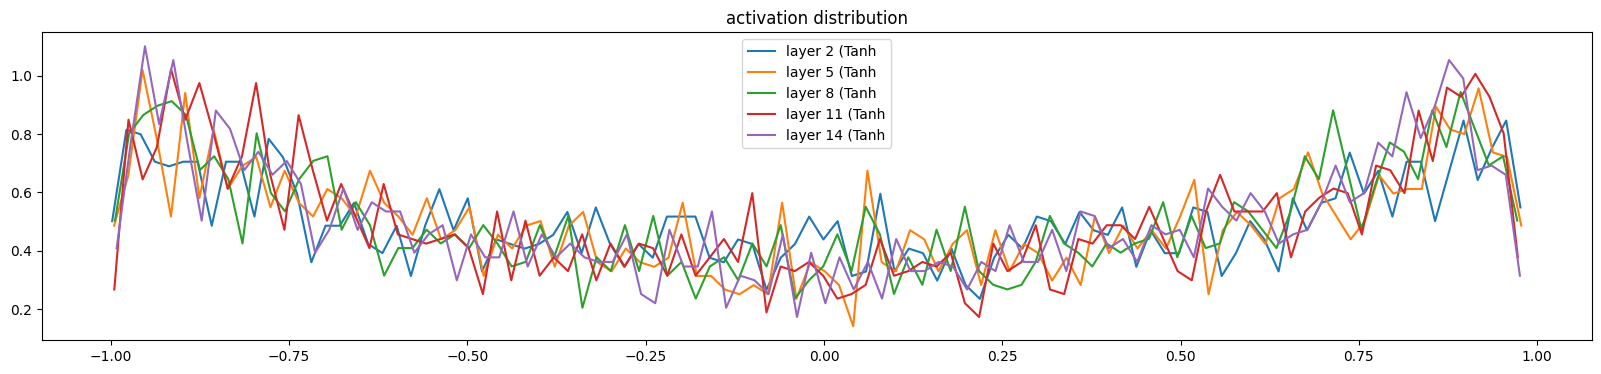

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.162614e-03
layer 5 (      Tanh): mean -0.000000, std 2.524563e-03
layer 8 (      Tanh): mean -0.000000, std 2.240847e-03
layer 11 (      Tanh): mean -0.000000, std 2.065109e-03
layer 14 (      Tanh): mean +0.000000, std 2.072680e-03


Text(0.5, 1.0, 'gradient distribution')

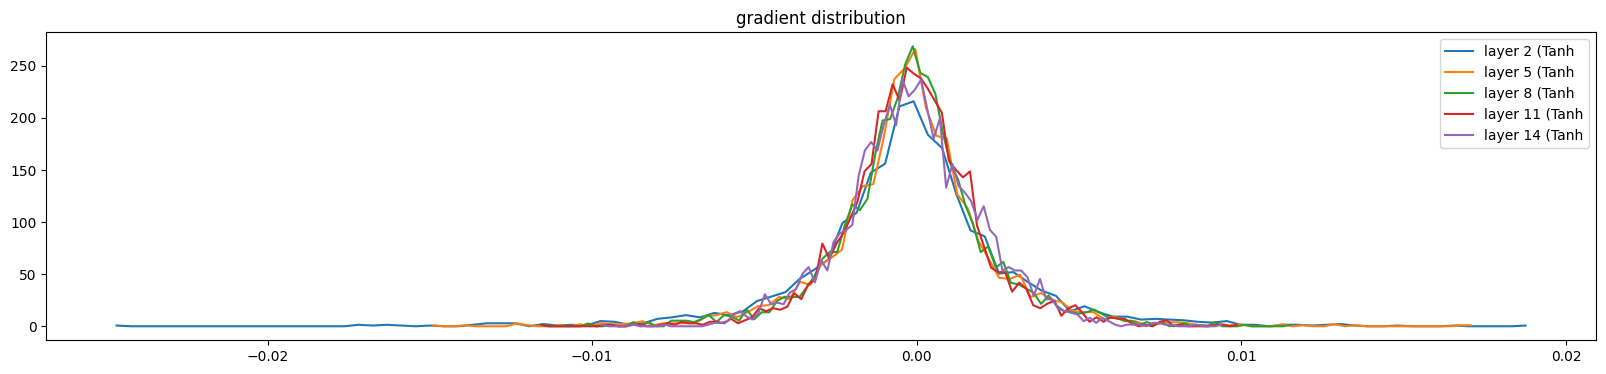

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.294079e-02 | grad:data ratio 1.318530e-02
weight  (30, 100) | mean +0.000037 | std 1.423754e-02 | grad:data ratio 7.530253e-02
weight (100, 100) | mean -0.000177 | std 9.459224e-03 | grad:data ratio 9.243696e-02
weight (100, 100) | mean +0.000035 | std 7.485794e-03 | grad:data ratio 7.227922e-02
weight (100, 100) | mean +0.000070 | std 6.666477e-03 | grad:data ratio 6.551484e-02
weight (100, 100) | mean -0.000107 | std 5.868669e-03 | grad:data ratio 5.721446e-02
weight  (100, 27) | mean +0.000055 | std 1.188065e-02 | grad:data ratio 1.124636e-01


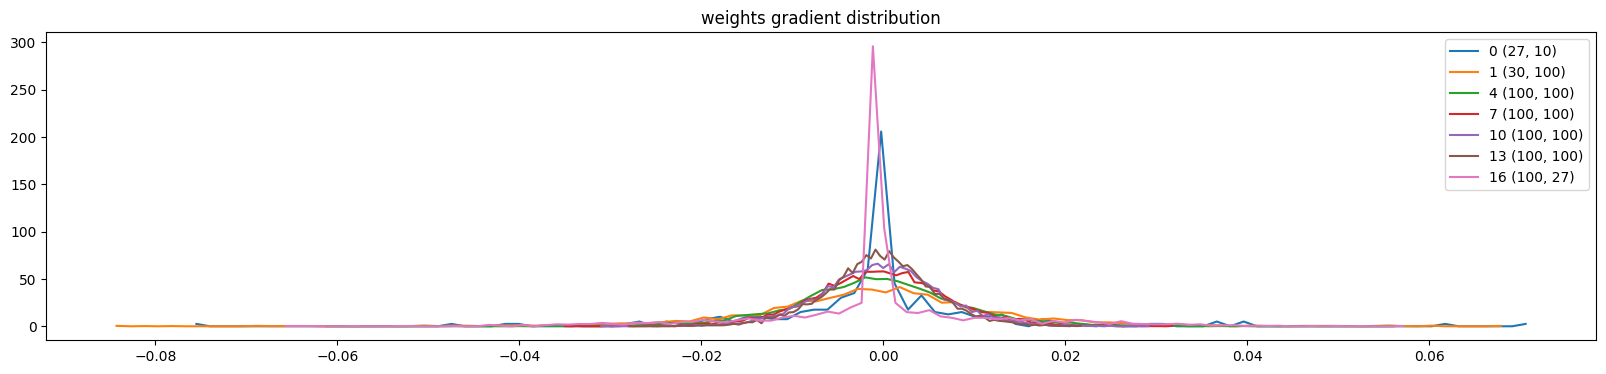

In [50]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

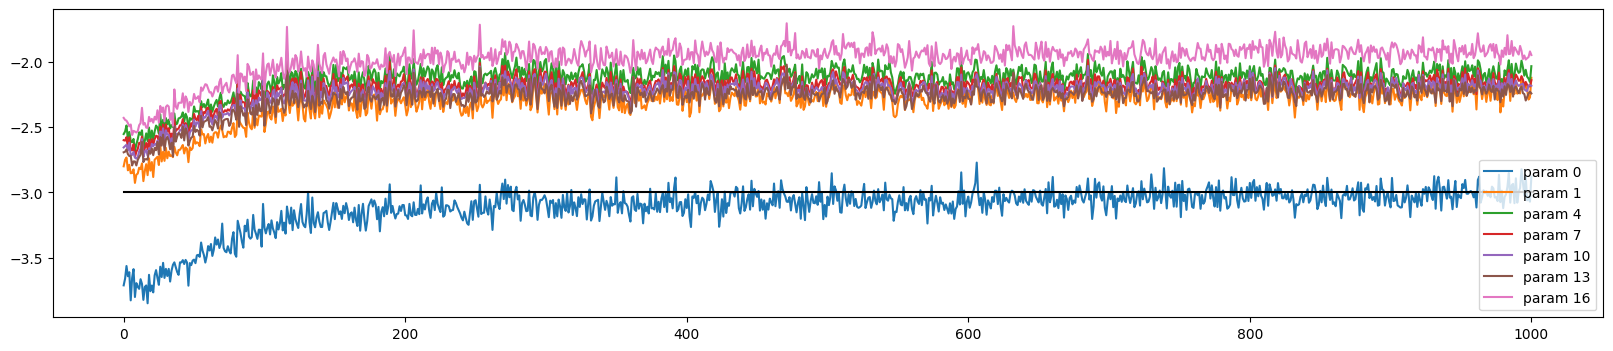

In [51]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [97]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.508368968963623
val 2.220060348510742


In [99]:
# sample from the model
g = torch.Generator().manual_seed(5)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

karum.
dipal.
benpa.
samim.
shilawan.
puspen.
ronchn.
sitara.
mehak.
humendra.
shelauddin.
chander.
ramkishan.
shan.
aashudevlash.
ntum.
siya.
ratni.
tainitasha.
palllu.
